In [1]:
import sympy as sp
from sympy import oo
import numpy as np
from itertools import product
from scipy.linalg import eig
from sympy import diff
import time as time
import matplotlib.pyplot as plt
from sympy.plotting import plot
# %matplotlib notebook 
%matplotlib inline
from IPython.display import Math
sp.init_printing()

r, r1, r2, zeta, zeta1, zeta2 = sp.symbols("r, r1, r2, zeta, zeta1, zeta2")
n = sp.Symbol('n',integer=True)

In [2]:
def STO(zeta, n, r=r):
    return (2*zeta)**n*(2*zeta/sp.factorial(2*n))**(1/2)*r**(n-1)*sp.exp(-zeta*r)

In [3]:
# S Overlap Integrate
def S_int(f1, f2):
    return sp.integrate(f1*f2*r*r ,(r, 0, +oo))

In [4]:
# H core = kinetics energy + electron and nuclear potential energy
def Hs_int(f1, f2, Z):
    return sp.integrate(f1*(-((1/2)*(1/r)*diff(diff(r*f2, r), r))-((Z/r)*f2))*r*r, (r,0,+oo))

In [5]:
# H core = kinetics energy + electron and nuclear potential energy
def Hp_int(f1, f2, Z):
    return sp.integrate(f1*(-((1/2)*(1/r)*diff(diff(r*f2, r), r))+((1/r**2)*f2)-((Z/r)*f2))*r*r, (r,0,+oo))

In [6]:
# Returns the core hamiltonian matrix
def Hs_matrix(fs, Z):

    H = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            H[i, j] =  Hs_int(fs[i], fs[j], Z)

    return H    

# Returns the overlap matrix
def S_matrix(fs):

    S = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            S[i, j] =  S_int(fs[i], fs[j])

    return S

In [7]:
# Returns the core hamiltonian matrix
def Hp_matrix(fp, Z):

    H = np.zeros((len(fp),len(fp)))
    for i in range(len(fp)):
        for j in range(len(fp)):
            H[i, j] =  Hp_int(fp[i], fp[j], Z)

    return H    

In [8]:
def Repulsion_electron(zetas, l):
    
    f1=STO(zetas[0][0], zetas[0][1], r1)
    f2=STO(zetas[1][0], zetas[1][1], r1)
    f3=STO(zetas[2][0], zetas[2][1], r2)
    f4=STO(zetas[3][0], zetas[3][1], r2)
    fs = [f1, f2, f3, f4]
    
    B = (1/r1**(l+1))*sp.integrate(f3*f4*r2**(l+2) ,(r2, 0, r1)) + r1**l*sp.integrate(f3*f4*r2**(1-l) ,(r2, r1, +oo))
    A = sp.integrate(f1*f2*r1*r1*B ,(r1, 0, +oo))
    return A

In [9]:
# Calculates Density matrix
# P need to be changed if the atom have unpaired electron
def Ps_matrix(Co):

    P = np.zeros([Co.shape[0], Co.shape[0]])

    for t in range(Co.shape[0]):
        for u in range(Co.shape[0]):
            P[t][u] = 2* Co[t][0]*Co[u][0] + 2* Co[t][1]*Co[u][1]
    return P

In [10]:
# Calculates Density matrix
# P need to be changed if the atom have unpaired electron
def Pp_matrix(Co):

    P = np.zeros([Co.shape[0], Co.shape[0]])

    for t in range(Co.shape[0]):
        for u in range(Co.shape[0]):
            P[t][u] = 6* Co[t][0]*Co[u][0]
    return P

In [11]:
def J_matrix(zetai, zetaj):
    J = np.zeros((len(zetai), len(zetai), len(zetaj), len(zetaj)))

    rs = list(product(range(len(zetai)),repeat=2))
    tu = list(product(range(len(zetaj)),repeat=2))

    for r, s in rs:
        for t, u in tu:
            J[r,s,t,u] = Repulsion_electron((zetai[r], zetai[s], zetaj[t], zetaj[u]), 0)
    return J

def K_matrix(zetai, zetaj, l):
    K = np.zeros((len(zetai), len(zetai), len(zetaj), len(zetaj)))

    rs = list(product(range(len(zetai)),repeat=2))
    tu = list(product(range(len(zetaj)),repeat=2))

    for r, s in rs:
        for t, u in tu:
            K[r,s,t,u] = Repulsion_electron((zetai[r], zetaj[u], zetaj[t], zetai[s]), l)
    return K

# Caculate G Matrix for 1s
def Gs_matrix(Cos, Cop, Jss, Kss, Jsp, Ksp):

    G = np.zeros((Cos.shape[0], Cos.shape[0]))
    Ps = Ps_matrix(Cos)
    Pp = Pp_matrix(Cop)
    
    rs = list(product(range( Cos.shape[0]),repeat=2))
    tu = list(product(range( Cos.shape[0]),repeat=2))
    ij = list(product(range( Cop.shape[0]),repeat=2))

    for r, s in rs:
        g = 0
        for t, u in tu:
            int1 = Jss[r, s, t, u]
            int2 = Kss[r, s, t, u]
            g+= Ps[t, u] * (int1 - 0.5 * int2)
        for i, j in ij:
            int1 = Jsp[r, s, i, j]
            int2 = Ksp[r, s, i, j]
            g+= Pp[i, j] * (int1 - 0.5 * int2)
        G[r, s] = g
    return G

# Returns the Fock matrix
def Fs_matrix(fs, Z, Cos, Cop, Jss, Kss, Jsp, Ksp):
    return Hs_matrix(fs, Z) + Gs_matrix(Cos, Cop, Jss, Kss, Jsp, Ksp)

In [12]:
# Caculate G Matrix for p
def Gp_matrix(Cos, Cop, Jpp, Kpp, Jps, Kps):

    G = np.zeros((Cop.shape[0], Cop.shape[0]))
    Ps = Ps_matrix(Cos)
    Pp = Pp_matrix(Cop)
    
    rs = list(product(range( Cop.shape[0]),repeat=2))
    tu = list(product(range( Cop.shape[0]),repeat=2))
    ij = list(product(range( Cos.shape[0]),repeat=2))

    for r, s in rs:
        g = 0
        for t, u in tu:
            int1 = Jpp[r, s, t, u]
            int2 = Kpp[r, s, t, u]
            g+= Pp[t, u] * (int1 - 0.5 * int2)
        for i, j in ij:
            int1 = Jps[r, s, i, j]
            int2 = Kps[r, s, i, j]
            g+= Ps[i, j] * (int1 - 0.5 * int2)
        G[r, s] = g
    return G

# Returns the Fock matrix
def Fp_matrix(fp, Z, Cos, Cop, Jpp, Kpp, Jps, Kps):
    return Hp_matrix(fp, Z) + Gp_matrix(Cos, Cop, Jpp, Kpp, Jps, Kps)

In [13]:
# slove secular equation, return the energy and improved coeffients
# the energy here is orbital energy for 1 electron
def secular_eqn(F, S):
    ei, C = eig(F, S)
    
    # sort eigvalue and eigvector from lower to higher
    idx = ei.argsort()[::1]   
    ei = ei[idx]
    C = C[:,idx]

    # eigvector from scipy.linalg.eig is not normalized, which is a bug
    # this is to fix it
    Co = np.zeros((C.shape[0],C.shape[0]))
    inte = np.matmul(np.matmul(C.T, S), C)
    for i in range(C.shape[0]):
        for j in range(C.shape[0]):
            Co[j][i]=C[j][i]/np.sqrt(inte[i][i])

    return ei, Co

In [25]:
# return energy of atom
def get_E0(Fs, Fp, Ps, Pp, Hs, Hp):
    
    E0 = 0.5*(Ps*(Fs+Hs)).sum() + 0.5*(Pp*(Fp+Hp)).sum()
    return E0

------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion integral ------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

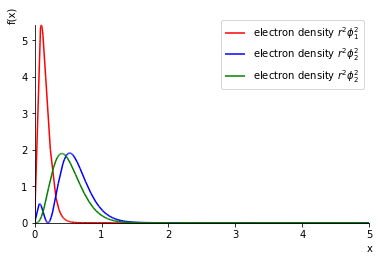

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------ Iteration 1 ------------------------------
------- Iteration 1 needs more time to caculate Repulsion Integral ------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

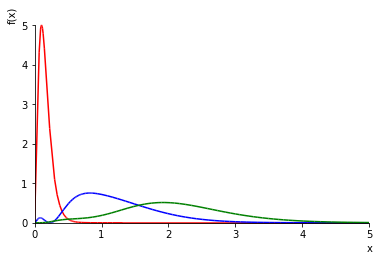

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 2 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

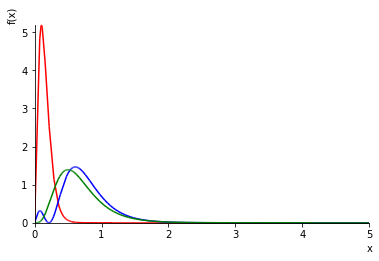

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 3 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

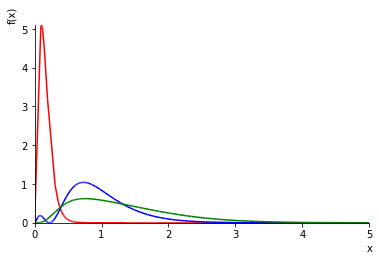

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 4 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

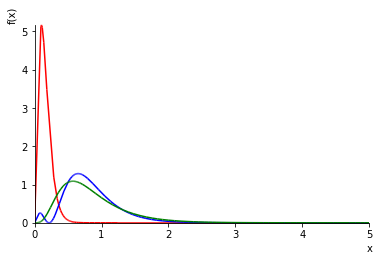

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 5 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

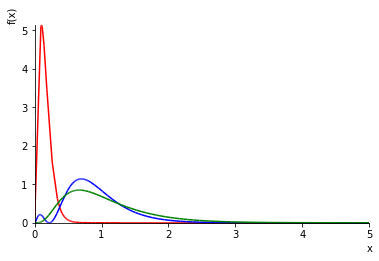

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.0 s
------------------------------ Iteration 6 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

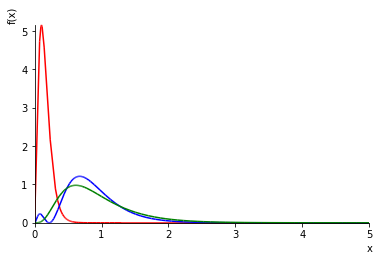

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 7 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

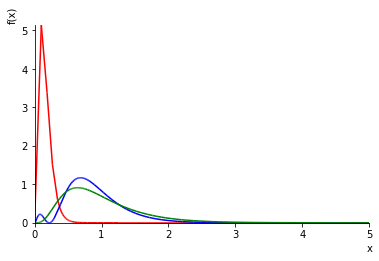

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 8 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

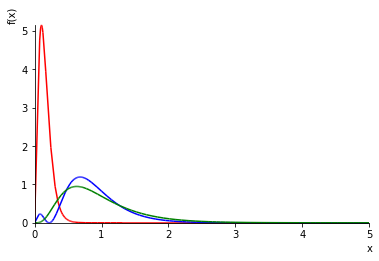

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 9 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

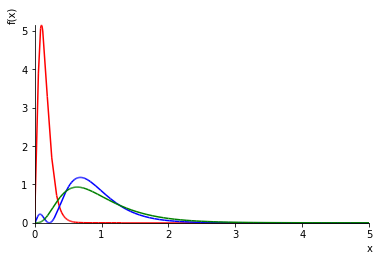

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.7 s
------------------------------ Iteration 10 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

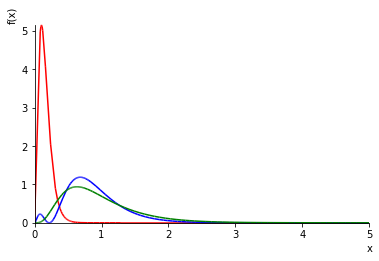

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.0 s
------------------------------ Iteration 11 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

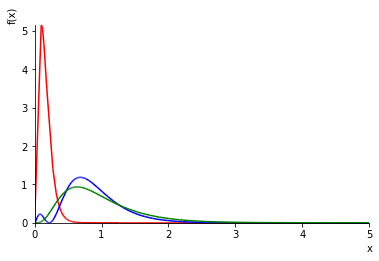

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 12 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

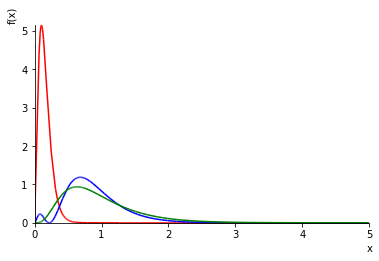

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 13 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

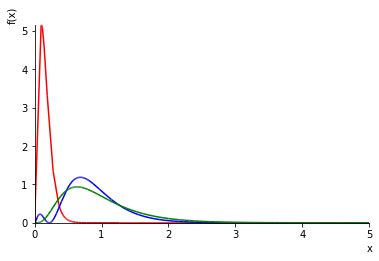

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 14 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

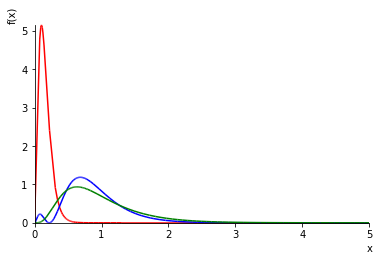

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 15 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

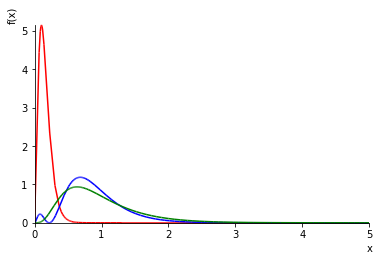

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 16 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

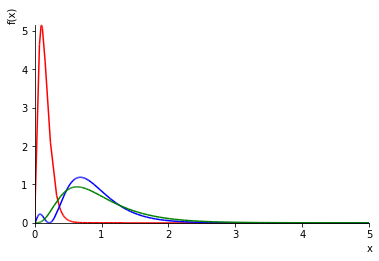

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.4 s
------------------------------ Iteration 17 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

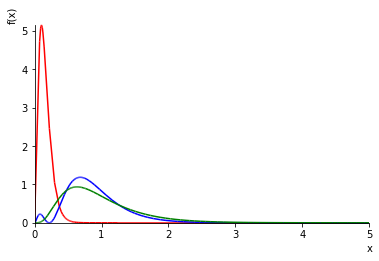

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.0 s
------------------------------ Iteration 18 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

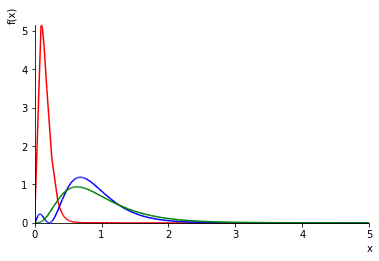

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.0 s
------------------------------ Iteration 19 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

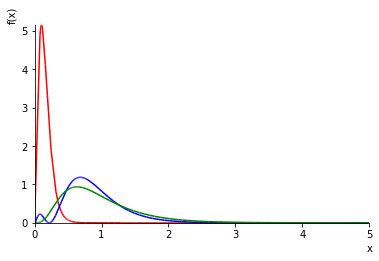

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 20 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

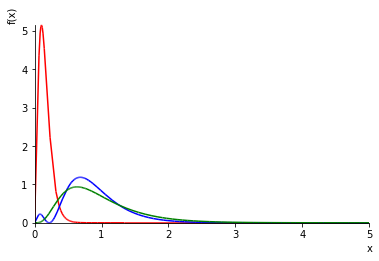

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.7 s
------------------------------ Iteration 21 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

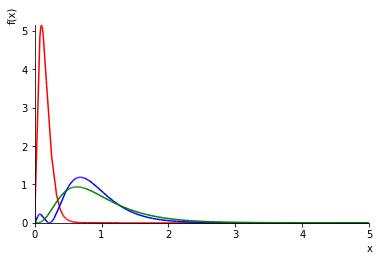

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 22 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

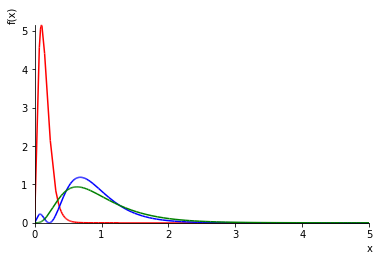

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 23 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

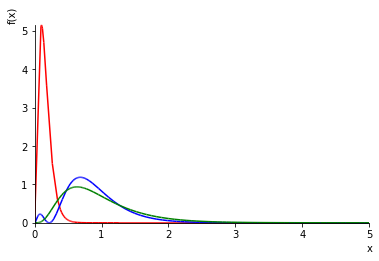

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 24 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

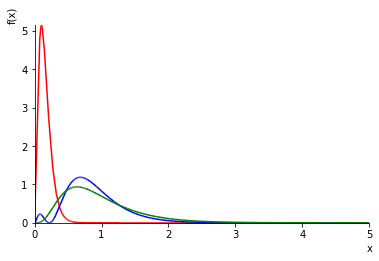

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 25 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

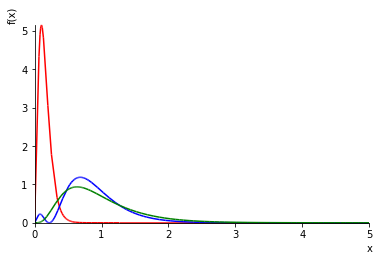

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 26 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

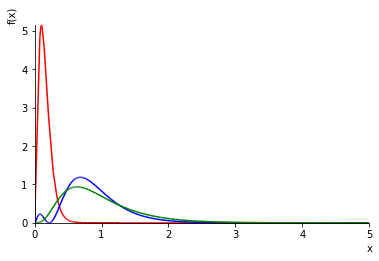

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 27 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

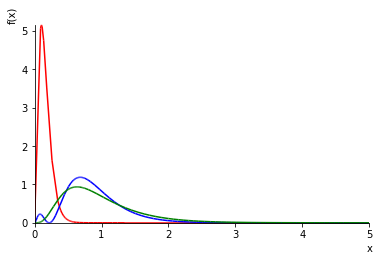

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.9 s
------------------------------ Iteration 28 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

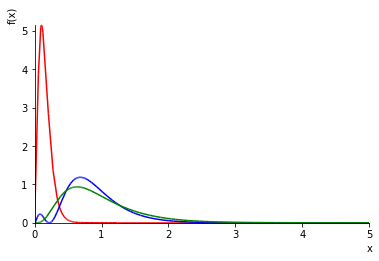

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.8 s
------------------------------ Iteration 29 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

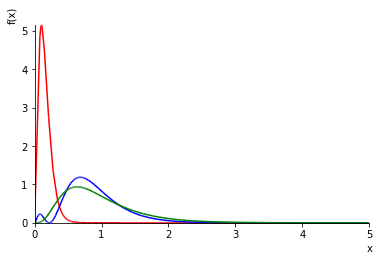

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 2.9 s
------------------------------ Iteration 30 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

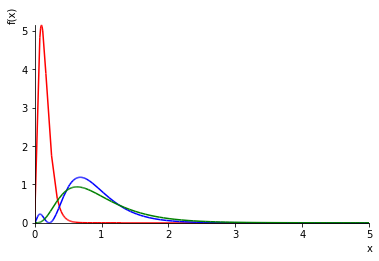

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 3.2 s


In [33]:
# input 
# zeta obtained from https://www.scm.com/zorabasis/periodic.dzae.html
zetas = [[9.48486, 1], [15.56590, 1], [1.96184, 2], [2.86423, 2], [4.82530, 2], [7.79242, 2]]
zetap = [[1.45208, 2], [2.38168, 2], [4.48489, 2], [9.13464, 2]]
# input nuclear charge (element number)
Z = 10

# build basis function
fs1=STO(zetas[0][0], zetas[0][1])
fs2=STO(zetas[1][0], zetas[1][1])
fs3=STO(zetas[2][0], zetas[2][1])
fs4=STO(zetas[3][0], zetas[3][1])
fs5=STO(zetas[4][0], zetas[4][1])
fs6=STO(zetas[5][0], zetas[5][1])
fs = [fs1, fs2, fs3, fs4, fs5, fs6]

fp1=STO(zetap[0][0], zetap[0][1])
fp2=STO(zetap[1][0], zetap[1][1])
fp3=STO(zetap[2][0], zetap[2][1])
fp4=STO(zetap[3][0], zetap[3][1])
fp = [fp1, fp2, fp3, fp4]

# initialization
#Jss = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))
#Kss = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))
#Jsp = np.zeros((len(zetas), len(zetas), len(zetap), len(zetap)))
#Ksp = np.zeros((len(zetas), len(zetas), len(zetap), len(zetap)))
#Jps = np.zeros((len(zetap), len(zetap), len(zetas), len(zetas)))
#Kps = np.zeros((len(zetap), len(zetap), len(zetas), len(zetas)))
#Jpp = np.zeros((len(zetas), len(zetas), len(zetap), len(zetap)))
#Kpp = np.zeros((len(zetas), len(zetas), len(zetap), len(zetap)))
Hs = Hs_matrix(fs, Z)
Hp = Hp_matrix(fp, Z)
Ss = S_matrix(fs)
Sp = S_matrix(fp)
es, Cos = secular_eqn(Hs, Ss)
ep, Cop = secular_eqn(Hp, Sp)
Ps = Ps_matrix(Cos)
Pp = Pp_matrix(Cop)
scf_H = get_E0(Hs, Hp, Ps, Pp, Hs, Hp)

##############################################print information below#################################################
print('-'*30, "Initialization", '-'*30)
print('-'*25, "Ignore repulsion integral", '-'*24)
display(Math('\zeta_1 = {0} \quad \zeta_2 = {1} \quad \zeta_3 = {2} \quad \zeta_4 = {3} \quad \zeta_5 = {4} \quad \zeta_6 = {5}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), format(zetas[2][0], '0.3f'),format(zetas[3][0], '0.3f'), format(zetas[4][0], '0.3f'),format(zetas[5][0], '0.3f')))) 
display(Math('\zeta_7 = {0} \quad \zeta_8 = {1} \quad \zeta_9 = {2} \quad \zeta_10 = {3}'.format(format(zetap[0][0], '0.3f'),format(zetap[1][0], '0.3f'), format(zetap[2][0], '0.3f'),format(zetap[3][0], '0.3f')))) 
display(Math('Orbitals:'))
display(Math(' \phi_1s = c_{11} \chi_1 + c_{21} \chi_2 + c_{31} \chi_3 + c_{41} + c_{51} \chi_3 + c_{61} \chi_4'))
display(Math(' \phi_2s = c_{12} \chi_1 + c_{22} \chi_2 + c_{32} \chi_3 + c_{42} + c_{51} \chi_3 + c_{61} \chi_4'))    
display(Math(' \phi_2p = c_{72} \chi_5 + c_{82} \chi_6 + c_{92} \chi_5 + c_{102} \chi_6')) 
display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c51 = {4} \quad c61 = {5}'.format(format(Cos[0][0], '0.3f'), format(Cos[1][0], '0.3f'), format(Cos[2][0], '0.3f'), format(Cos[3][0], '0.3f'), format(Cos[4][0], '0.3f'), format(Cos[5][0], '0.3f')))) 
display(Math('c12 = {0} \quad c22 = {1} \quad c32 = {2} \quad c42 = {3} \quad c52 = {4} \quad c62 = {5}'.format(format(Cos[0][1], '0.3f'), format(Cos[1][1], '0.3f'), format(Cos[2][1], '0.3f'), format(Cos[3][1], '0.3f'), format(Cos[4][1], '0.3f'), format(Cos[5][1], '0.3f'))))     
display(Math('c72 = {0} \quad c82 = {1} \quad c92 = {2} \quad c102 = {3}'.format(format(Cop[0][0], '0.3f'), format(Cop[1][0], '0.3f'), format(Cop[2][0], '0.3f'), format(Cop[3][0], '0.3f'))))     

# plot density graph
colorlist = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black']
phi1 = Cos[0,0]*fs1+Cos[1,0]*fs2+Cos[2,0]*fs3+Cos[3,0]*fs4+Cos[4,0]*fs5+Cos[5,0]*fs6
phi2 = Cos[0,1]*fs1+Cos[1,1]*fs2+Cos[2,1]*fs3+Cos[3,1]*fs4+Cos[4,1]*fs5+Cos[5,1]*fs6
phi3 = Cop[0,0]*fp1+Cop[1,0]*fp2+Cop[2,0]*fp3+Cop[3,0]*fp4
density_1 = phi1*phi1*r*r
density_2 = phi2*phi2*r*r    
density_3 = phi3*phi3*r*r   
p = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), (density_3, (r, 0, 5)), show = False, legend = True)
p[0].label = 'electron density $r^2 \phi_1^2$ '
p[1].label = 'electron density $r^2 \phi_2^2$ '    
p[2].label = 'electron density $r^2 \phi_2^2$ ' 
p[0].line_color = colorlist[0]
p[1].line_color = 'blue'
p[2].line_color = 'green'
p.show()
# print energy result
display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(es[0].real, '0.3f'))))    
display(Math(' \epsilon_2 \; for \; \phi_2 = {0} '.format(format(es[1].real, '0.3f'))))      
display(Math(' \epsilon_3 \; for \; \phi_3 = {0} '.format(format(ep[0].real, '0.3f'))))   
display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))    

##############################################print information above#################################################

for i in range(30):
    print('-'*30, "Iteration", i + 1, '-'*30)
    if(i==0):
        print('-'*7, "Iteration 1 needs more time to caculate Repulsion Integral", '-'*6)
        start = time.time()
        #Jss = J_matrix(zetas, zetas)
        #Kss = K_matrix(zetas, zetas, 0)
        #Jsp = J_matrix(zetas, zetap)
        #Ksp = 1/3 * K_matrix(zetas, zetap, 1)
        #Jps = J_matrix(zetap, zetas)
        #Kps = 1/3 * K_matrix(zetap, zetas, 1)
        #Jpp = J_matrix(zetap, zetap)
        #Kpp = 1/3 * K_matrix(zetap, zetap, 0) + 2/15 * K_matrix(zetap, zetap, 2)
    else:
        start = time.time()
    Fs = Fs_matrix(fs, Z, Cos, Cop, Jss, Kss, Jsp, Ksp)
    Fp = Fp_matrix(fp, Z, Cos, Cop, Jpp, Kpp, Jps, Kps)
    S = S_matrix(fs)
    es, Cos = secular_eqn(Fs, Ss)
    ep, Cop = secular_eqn(Fp, Sp)
    Ps = Ps_matrix(Cos)
    Pp = Pp_matrix(Cop)
    scf_H = get_E0(Fs, Fp, Ps, Pp, Hs, Hp)
    ##########################################print information below#################################################
    # print information
    display(Math('\zeta_1 = {0} \quad \zeta_2 = {1} \quad \zeta_3 = {2} \quad \zeta_4 = {3} \quad \zeta_5 = {4} \quad \zeta_6 = {5}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), format(zetas[2][0], '0.3f'),format(zetas[3][0], '0.3f'), format(zetas[4][0], '0.3f'),format(zetas[5][0], '0.3f')))) 
    display(Math('\zeta_7 = {0} \quad \zeta_8 = {1} \quad \zeta_9 = {2} \quad \zeta_10 = {3}'.format(format(zetap[0][0], '0.3f'),format(zetap[1][0], '0.3f'), format(zetap[2][0], '0.3f'),format(zetap[3][0], '0.3f')))) 
    display(Math('Orbitals:'))
    display(Math(' \phi_1s = c_{11} \chi_1 + c_{21} \chi_2 + c_{31} \chi_3 + c_{41} + c_{51} \chi_3 + c_{61} \chi_4'))
    display(Math(' \phi_2s = c_{12} \chi_1 + c_{22} \chi_2 + c_{32} \chi_3 + c_{42} + c_{51} \chi_3 + c_{61} \chi_4'))    
    display(Math(' \phi_2p = c_{72} \chi_5 + c_{82} \chi_6 + c_{92} \chi_5 + c_{102} \chi_6')) 
    display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3} \quad c51 = {4} \quad c61 = {5}'.format(format(Cos[0][0], '0.3f'), format(Cos[1][0], '0.3f'), format(Cos[2][0], '0.3f'), format(Cos[3][0], '0.3f'), format(Cos[4][0], '0.3f'), format(Cos[5][0], '0.3f')))) 
    display(Math('c12 = {0} \quad c22 = {1} \quad c32 = {2} \quad c42 = {3} \quad c52 = {4} \quad c62 = {5}'.format(format(Cos[0][1], '0.3f'), format(Cos[1][1], '0.3f'), format(Cos[2][1], '0.3f'), format(Cos[3][1], '0.3f'), format(Cos[4][1], '0.3f'), format(Cos[5][1], '0.3f'))))     
    display(Math('c72 = {0} \quad c82 = {1} \quad c92 = {2} \quad c102 = {3}'.format(format(Cop[0][0], '0.3f'), format(Cop[1][0], '0.3f'), format(Cop[2][0], '0.3f'), format(Cop[3][0], '0.3f'))))     
    # plot density graph
    phi1 = Cos[0,0]*fs1+Cos[1,0]*fs2+Cos[2,0]*fs3+Cos[3,0]*fs4+Cos[4,0]*fs5+Cos[5,0]*fs6
    phi2 = Cos[0,1]*fs1+Cos[1,1]*fs2+Cos[2,1]*fs3+Cos[3,1]*fs4+Cos[4,1]*fs5+Cos[5,1]*fs6
    phi3 = Cop[0,0]*fp1+Cop[1,0]*fp2+Cop[2,0]*fp3+Cop[3,0]*fp4
    density_1 = phi1*phi1*r*r
    density_2 = phi2*phi2*r*r    
    density_3 = phi3*phi3*r*r    
    p = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), (density_3, (r, 0, 5)), show = False)
    p[0].label = 'electron density $r^2 \phi_1^2$ '
    p[1].label = 'electron density $r^2 \phi_2^2$ '    
    p[2].label = 'electron density $r^2 \phi_2^2$ ' 
    p[0].line_color = colorlist[0]
    p[1].line_color = 'blue'
    p[2].line_color = 'green'
    p.show()
    # print energy result
    display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(es[0].real, '0.3f'))))    
    display(Math(' \epsilon_2 \; for \; \phi_2 = {0} '.format(format(es[1].real, '0.3f'))))      
    display(Math(' \epsilon_3 \; for \; \phi_3 = {0} '.format(format(ep[0].real, '0.3f'))))   
    display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))   
    stop = time.time()
    print('Time used:',format(stop-start, '0.1f'),'s')
    ##########################################print information above#################################################


In [34]:
print(sp.integrate(density_1 ,(r, 0, +oo)))
print(sp.integrate(density_1/r ,(r, 0, +oo)))
print(sp.integrate(density_1*r ,(r, 0, +oo)))
print(sp.integrate(density_1*r*r ,(r, 0, +oo)))

print(sp.integrate(density_2 ,(r, 0, +oo)))
print(sp.integrate(density_2/r ,(r, 0, +oo)))
print(sp.integrate(density_2*r ,(r, 0, +oo)))
print(sp.integrate(density_2*r*r ,(r, 0, +oo)))

print(sp.integrate(density_3 ,(r, 0, +oo)))
print(sp.integrate(density_3/r/r/r ,(r, 0, +oo)))
print(sp.integrate(density_3/r ,(r, 0, +oo)))
print(sp.integrate(density_3*r ,(r, 0, +oo)))
print(sp.integrate(density_3*r*r ,(r, 0, +oo)))

1.00000000000000
9.61804167238766
0.157630635770063
0.0334695250426786
1.00000000000000
1.63255436275460
0.892121593140552
0.967157198911206
1.00000000000000
10.8993878282131
1.43534269367136
0.965346099451628
1.22909128494714


Reference:
1. Larsen, A. and R. S. Poulsen (2015). Applied Hartree-Fock methods: Atomic and diatomic energy computations. Department of Physics. Denmark, Aalborg University. Master: 68.
2. Bransden, B. H. (2003). Physics of atoms and molecules. Harlow, England


In [27]:
print(es)
print(ep)

[-32.77254051+0.j  -1.93044779+0.j   0.77490945+0.j   5.35925949+0.j
  29.44591824+0.j 229.85362257+0.j]
[-0.85045831+0.j  0.72725614+0.j  4.59293276+0.j 34.27021444+0.j]


In [30]:
print((Ps*Fs).sum())
print((Pp*Fp).sum())

-69.4059766013363
4.154542530805603
